In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib notebook

Input Aperture Radius: 10
Input Inner Annulus' Radius: 20
Input Outer Annulus' Radius: 40
Input Target Coordinates: 280 242
Input Reference Coordinates: 273 325


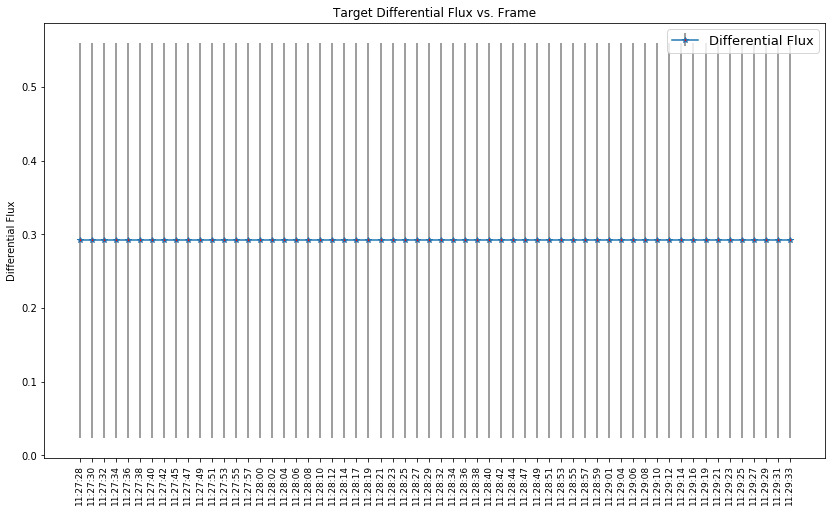

In [7]:
def CreateAnnulus(target,mask,thick):
    outerannulus = np.multiply(flat_subtracted,mask)
    innerannulus = np.multiply(flat_subtracted,thick)
    aperture     = np.multiply(flat_subtracted,target)
    outerannulus[np.isnan(outerannulus)] = 0
    innerannulus[np.isnan(innerannulus)] = 0
    aperture[np.isnan(aperture)]         = 0
    annulus = np.subtract(outerannulus,innerannulus)
    avg_annulus = np.sum(annulus)/np.count_nonzero(annulus)
    starcounts  = np.sum(aperture)-(avg_annulus*np.count_nonzero(aperture))
    uncertainty = np.sqrt(starcounts+np.sum(aperture)+np.count_nonzero(aperture)*(10**2))
    return starcounts,uncertainty

def main():
    CompArray = []
    DataArray = []
    FrameTime = []
    DataCountsArray = []
    DataUncertainty = []
    CompCountsArray = []
    CompUncertainty = []
    np.seterr(divide='ignore',invalid='ignore')
    radius = int(input("Input Aperture Radius: "))
    radiii = int(input("Input Inner Annulus' Radius: "))
    scopes = int(input("Input Outer Annulus' Radius: "))
    FitsFile = "/data/tnorecon/RECON_clean/yakima/"
    FitsDark = fits.getdata(FitsFile+"20201021/20201021_4.dark")
    FitsFlat = fits.getdata(FitsFile+"20201021/20201021_3.flat")
    x_axis,y_axis  = (int(num) for num in input("Input Target Coordinates: ").split())    # 280,242
    x_comp,y_comp  = (int(num) for num in input("Input Reference Coordinates: ").split()) # 273,325
    
    if radius < radiii < scopes:
        y_arr,x_arr = np.shape(FitsFlat)
        y_arr,x_arr = np.ogrid[:y_arr,:x_arr]
        normalized  = FitsFlat/(np.median(FitsFlat))
        reference_mask      = (x_arr-273)**2 + (y_arr-325)**2 <= scopes**2
        reference_aperture  = (x_arr-273)**2 + (y_arr-325)**2 <= radius**2
        reference_thickness = (x_arr-273)**2 + (y_arr-325)**2 <= radiii**2
        target_mask         = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= scopes**2
        target_aperture     = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= radius**2
        target_thickness    = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= radiii**2
        
        for reconFiles in range(100,160):
            FitsData,header = fits.getdata(FitsFile+f"20201021/20201021_2/00{reconFiles}.fits",header=True)
            dark_subtracted = np.subtract(FitsData,FitsDark)
            flat_subtracted = np.true_divide(dark_subtracted,normalized)
            DataArray.append(CreateAnnulus(target_aperture,target_mask,target_thickness))
            CompArray.append(CreateAnnulus(reference_aperture,reference_mask,reference_thickness))
            FrameTime.append(header['DATE-OBS'])
        for each in DataArray:
            DataCountsArray.append(each[0])
            DataUncertainty.append(each[1])
        for each in CompArray:
            CompCountsArray.append(each[0])
            CompUncertainty.append(each[1])
        for index,each in enumerate(FrameTime):
            FrameTime[index]=each[11:19]
            
        SigmaA    = [int(a)/int(b) for a,b in zip(DataUncertainty,DataCountsArray)]
        SigmaB    = [int(a)/int(b) for a,b in zip(CompUncertainty,CompCountsArray)]
        DiffFlux  = [int(a)/int(b) for a,b in zip(DataCountsArray,CompCountsArray)]
        SigmaDiff = [(c)*np.sqrt((a)**2+(b)**2) for a,b,c in zip(SigmaA,SigmaB,DiffFlux)]
        
        plt.figure(figsize=(14,8)) 
        plt.rc('xtick',labelsize=9)
        plt.errorbar(FrameTime,DiffFlux,yerr=SigmaDiff,mfc='red',label='Differential Flux',fmt='-*',ecolor='grey')
        plt.title('Target Differential Flux vs. Frame')
        plt.legend(loc='upper right',prop={'size':13})
        plt.ylabel('Differential Flux')
        plt.xticks(rotation=90)
        
    else:
        sys.exit("Please Imput Valid Values")

if __name__ == "__main__":
    main()

### 